In this example we load a pre-trained model and fit it for ONLY ONE EPOCH for illustration purpose. please consider migrating this code to a GPU environment to fit such a task without a pre-trained model.

### Import necessary pacakge

In [21]:
from swat import *
from pprint import pprint

import json
import sys

import dlpy
from dlpy.layers import * 
from dlpy.applications import *
from dlpy import Model, Sequential
from dlpy.utils import *
from dlpy.splitting import two_way_split
from dlpy.images import *
from dlpy.model import *
from dlpy.lr_scheduler import *
from dlpy.network import *

import cv2

### Connect to CAS

In [2]:
server_machine = 'your_machine'
server_port = 451
conn = CAS(server_machine, server_port)
conn.loadactionset('deepLearn')
conn.loadactionset('image')

NOTE: Added action set 'deepLearn'.
NOTE: Added action set 'image'.


[actionset]

 'image'

+ Elapsed: 0.00134s, user: 0.000175s, sys: 0.00114s, mem: 0.22mb

### Objective
The objective of the task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:
    1. tracking faces in images and video
    2. analysing facial expressions
    3. detecting dysmorphic facial signs for medical diagnosis
    4. biometrics / face recognition

Data:
    1. 96 * 96 grayscale images of cropped human faces.
    2. 15 keypoints
    3. Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices.


### Load training dataset
The train data is sourced from a Kaggle competition which can be found at https://www.kaggle.com/c/facial-keypoints-detection/data.

In [3]:
data_path = 'full_path_to_your_data'
# initial weights
initial_weights_path = 'full_path_to_initial_weights'
with caslibify_context(conn, data_path, task='load') as (caslib, path):
    conn.table.loadtable(casout={'name':'trainSet', 'replace':True},
                      caslib=caslib ,path=path)
with caslibify_context(conn, initial_weights_path, task='load') as (caslib, path):    
    conn.table.loadtable(casout={'name':'initial_weights', 'replace':True},
                      caslib=caslib ,path=path)

NOTE: Cloud Analytic Services made the file FacialKeyPoints.sashdat available as table TRAINSET in caslib CASUSER( ).
NOTE: Cloud Analytic Services made the file facial_keypoints_det_workshop_initweights.sashdat available as table INITIAL_WEIGHTS in caslib CASUSER( ).


In [4]:
conn.fetch('trainset', sastypes=False, to=5)

,imgNo,_image_,_size_,_path_,_label_,_type_,_id_,filename,left_eye_center_x,left_eye_center_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,Facial1881,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2202,/FacialKeyPoint/TrainImg/Facia...,,jpg,982,Facial1881,0.374,-0.257,...,0.05480,0.0926,0.361,0.510,-0.261,0.526,0.06620,0.461,0.06420,0.515
1,Facial1882,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,1887,/FacialKeyPoint/TrainImg/Facia...,,jpg,983,Facial1882,0.442,-0.181,...,0.00724,0.3160,0.326,0.736,-0.317,0.736,0.00159,0.717,-0.00187,0.766
2,Facial1883,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2130,/FacialKeyPoint/TrainImg/Facia...,,jpg,984,Facial1883,0.532,-0.132,...,-0.13500,0.1560,0.372,0.748,-0.491,0.612,-0.12700,0.648,-0.13800,0.768
3,Facial1884,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2031,/FacialKeyPoint/TrainImg/Facia...,,jpg,985,Facial1884,0.342,-0.195,...,0.11300,0.2390,0.321,0.602,-0.329,0.615,0.05770,0.633,0.07050,0.642
4,Facial1885,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,2227,/FacialKeyPoint/TrainImg/Facia...,,jpg,986,Facial1885,0.329,-0.227,...,-0.09380,0.3120,0.265,0.795,-0.531,0.754,-0.15200,0.726,-0.15000,0.751


In [5]:
conn.shuffle(table=dict(name='trainSet'), casout=dict(name='train', blocksize=4,replace=True))

[caslib]

 'CASUSER( )'

[tableName]

 'TRAIN'

[casTable]

 CASTable('TRAIN', caslib='CASUSER( )')

+ Elapsed: 0.0246s, user: 0.0239s, sys: 0.0384s, mem: 141mb

### Build CNN model
Next, let's build a CNN model comprised of convolution layer, pooling layer and dense layer. The model ends up with a Keypoints layer which is responsible for calculating regression error and back-propagating gradients. Keypoints layer allows you to specify error function and number of neurons. In the case, n(number of neurons) is set as 30 because there will be at most 15 landmarks on each image and each of landmarks requires two value, x and y, to describe the location. 

In [6]:
model_name='facial_keypoints'

model = Sequential(conn=conn, model_table=model_name)

model.add(InputLayer(n_channels=1, width=96, height=96, scale = 1.0 / 255))

model.add(Conv2d(n_filters=32, width=3, act='relu', stride=1))
model.add(Pooling(width=2, height=2, stride = 2, pool='max'))

model.add(Conv2d(n_filters=64, width=3, act='relu', stride=1))
model.add(Pooling(width=2, height=2, stride = 2, pool='max'))

model.add(Conv2d(n_filters=128, width=3, act='relu', stride=1))
model.add(Pooling(width=2, height=2, stride = 2, pool='max'))

model.add(Dense(n=500, act='relu'))
model.add(Dense(n=500, act='relu'))

# new feature, keypoints layer
model.add(Keypoints(n=30))

NOTE: Input layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Convolution layer added.
NOTE: Pooling layer added.
NOTE: Fully-connected layer added.
NOTE: Fully-connected layer added.
NOTE: Keypoints layer added.
NOTE: Model compiled successfully.


### Plot network
To enable graphic visualizations of DLPy deep learning models, it is recommended that you download and install the open source graph visualization software called Graphviz. <br>
Graphviz is available at https://www.graphviz.org/download/.

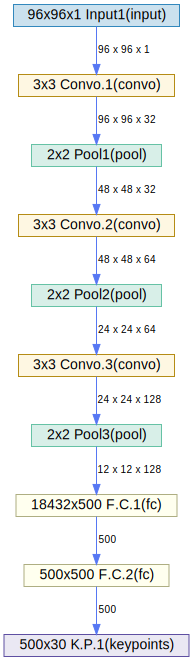

In [7]:
model.plot_network()

### Define target columns list
Variable targets is a list of target variable passed to K.P.1(keypoints layer).

In [8]:
targets = conn.columninfo('trainSet').ColumnInfo.Column.values[8:]

In [9]:
targets

array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y',
       'mouth_right_corner_x', 'mouth_right_corner_y',
       'mouth_center_top_lip_x', 'mouth_center_top_lip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y'],
      dtype=object)

### Train model

In [10]:
if conn.table.tableexists(name='initial_weights').exists:
    model.set_weights('initial_weights')

NOTE: Model weights attached successfully!


In [11]:
optimizer = Optimizer(mini_batch_size=12, log_level=3, max_epochs=1, reg_l2=0.0005,
                      algorithm=MomentumSolver(clip_grad_max=100, clip_grad_min=-100,
                                               learning_rate=0.000001, step_size=30))
data_specs = [DataSpec(type_='IMAGE', layer='Input1', data=['_image_']),
              DataSpec(type_='numnom', layer='K.P.1', data=targets.tolist())]
model.fit(data='train', optimizer=optimizer,
          # specify data type of input and output layers
          data_specs=data_specs,
          #gpu=dict(devices=0),
          n_threads = 10)

NOTE: Training based on existing weights.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 9574702.
NOTE:  The approximate memory cost is 1165.00 MB.
NOTE:  Loading weights cost       0.03 (s).
NOTE:  Initializing each layer cost       0.13 (s).
NOTE:  The total number of threads on each worker is 10.
NOTE:  The total mini-batch size per thread on each worker is 12.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 120.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Batch nUsed Learning Rate        Loss  Fit Error     L2Norm   Time(s) (Training)
NOTE:      0   120     1E-6          0.01431    0.02863     0.4749     0.22
NOTE:      1   120     1E-6          0.01281    0.02563     0.4749     0.22
NOTE:      2   120     1E-6          0.01248    0.02496     0.4749     0.21
NOTE:      3   120     1E-6          0.01386    0.02772     0.4749     0.22
NOTE:      4   120     1E-6        

,Descr,Value
0,Model Name,facial_keypoints
1,Model Type,Convolutional Neural Network
2,Number of Layers,10
3,Number of Input Layers,1
4,Number of Output Layers,0
5,Number of Convolutional Layers,3
6,Number of Pooling Layers,3
7,Number of Fully Connected Layers,2
8,Number of Keypoints Layers,1
9,Number of Weight Parameters,9573448


### Testing data

In [13]:
test = ImageTable.load_files(conn, path='/FacialKeyPoint/TestImg')

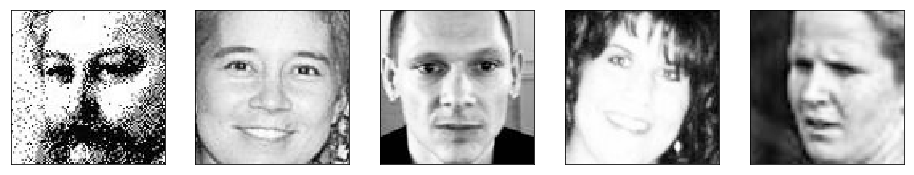

In [14]:
test.show()

### Get predictions

In [15]:
model.predict(data=test)

[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read          1783
 1  Number of Observations Used             0

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER( )  Valid_Res_cLDru3  1783       34   
 
                                             casTable  
 0  CASTable('Valid_Res_cLDru3', caslib='CASUSER(w...  

+ Elapsed: 0.783s, user: 21.5s, sys: 3.35s, mem: 2.43e+03mb

### Visualize predictions

In [16]:
numRecord = conn.numrows(model.valid_res_tbl)['numrows']
resultCol = ['I_{}'.format(x) for x in targets.tolist()]
resImg=conn.fetchimages(table=model.valid_res_tbl, to=numRecord).Images
resLabel = conn.fetch(model.valid_res_tbl, fetchvars=resultCol, to=numRecord).Fetch

NOTE: Table VALID_RES_CLDRU3 contains compressed images.


In [17]:
def imageShow(resImg, resLabel, image_list, ncol, figsize=None):
    nimages = len(image_list)

    if nimages > ncol:
        nrow = nimages // ncol + 1
    else:
        nrow = 1
        ncol = nimages

    if figsize is None:
        figsize = (16, 16 // ncol * nrow)

    fig = plt.figure(figsize=figsize)

    idxImg=1;
    for i in image_list:
        img = resImg.loc[i,'Image']
        imgarr = np.array(img)
        for k in range(0, 30, 2):
            x = int((resLabel.loc[i, 'I_{}'.format(targets.tolist()[k])]) * 48 + 48)
            y = int((resLabel.loc[i, 'I_{}'.format(targets.tolist()[k+1])]) * 48 + 48)
            cv2.circle(imgarr,(x, y), 1, (255,0,0), -1)
        ax = fig.add_subplot(nrow, ncol, idxImg)
        plt.imshow(imgarr, cmap='gray')
        # plt.title (str(r['Images']['_path_'].loc[i].split('.')[0]))
        idxImg=idxImg+1
        plt.xticks([]), plt.yticks([])
    plt.show()

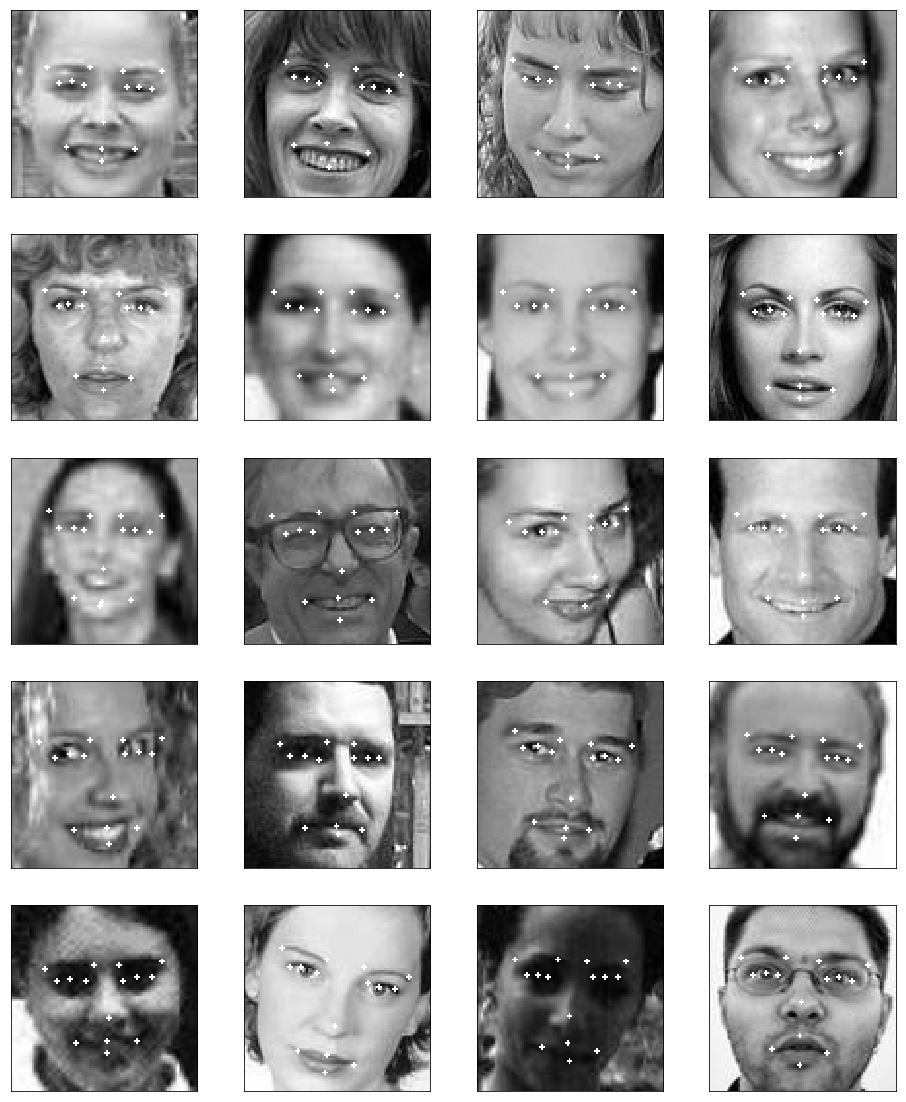

In [22]:
imageShow(resImg, resLabel, range(20, 40), 4)

### More applications of keypoint detection
Keypoint detection can be applied on fashion. Alibaba launched FashionAI competition this years. The competition concentrates on the key point localization of women apparel.

Besides, keypoint layer can be used to solve any multiple interval target regression problems.

In [23]:
conn.endsession()

+ Elapsed: 0.00011s, user: 8e-05s, sys: 8e-06s, mem: 0.205mb